In [3]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)


import gym
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.n_step_sarsa_agent import nStepSarsaAgent
from source.utils import *


test_n_step_sarsa_agent passed!


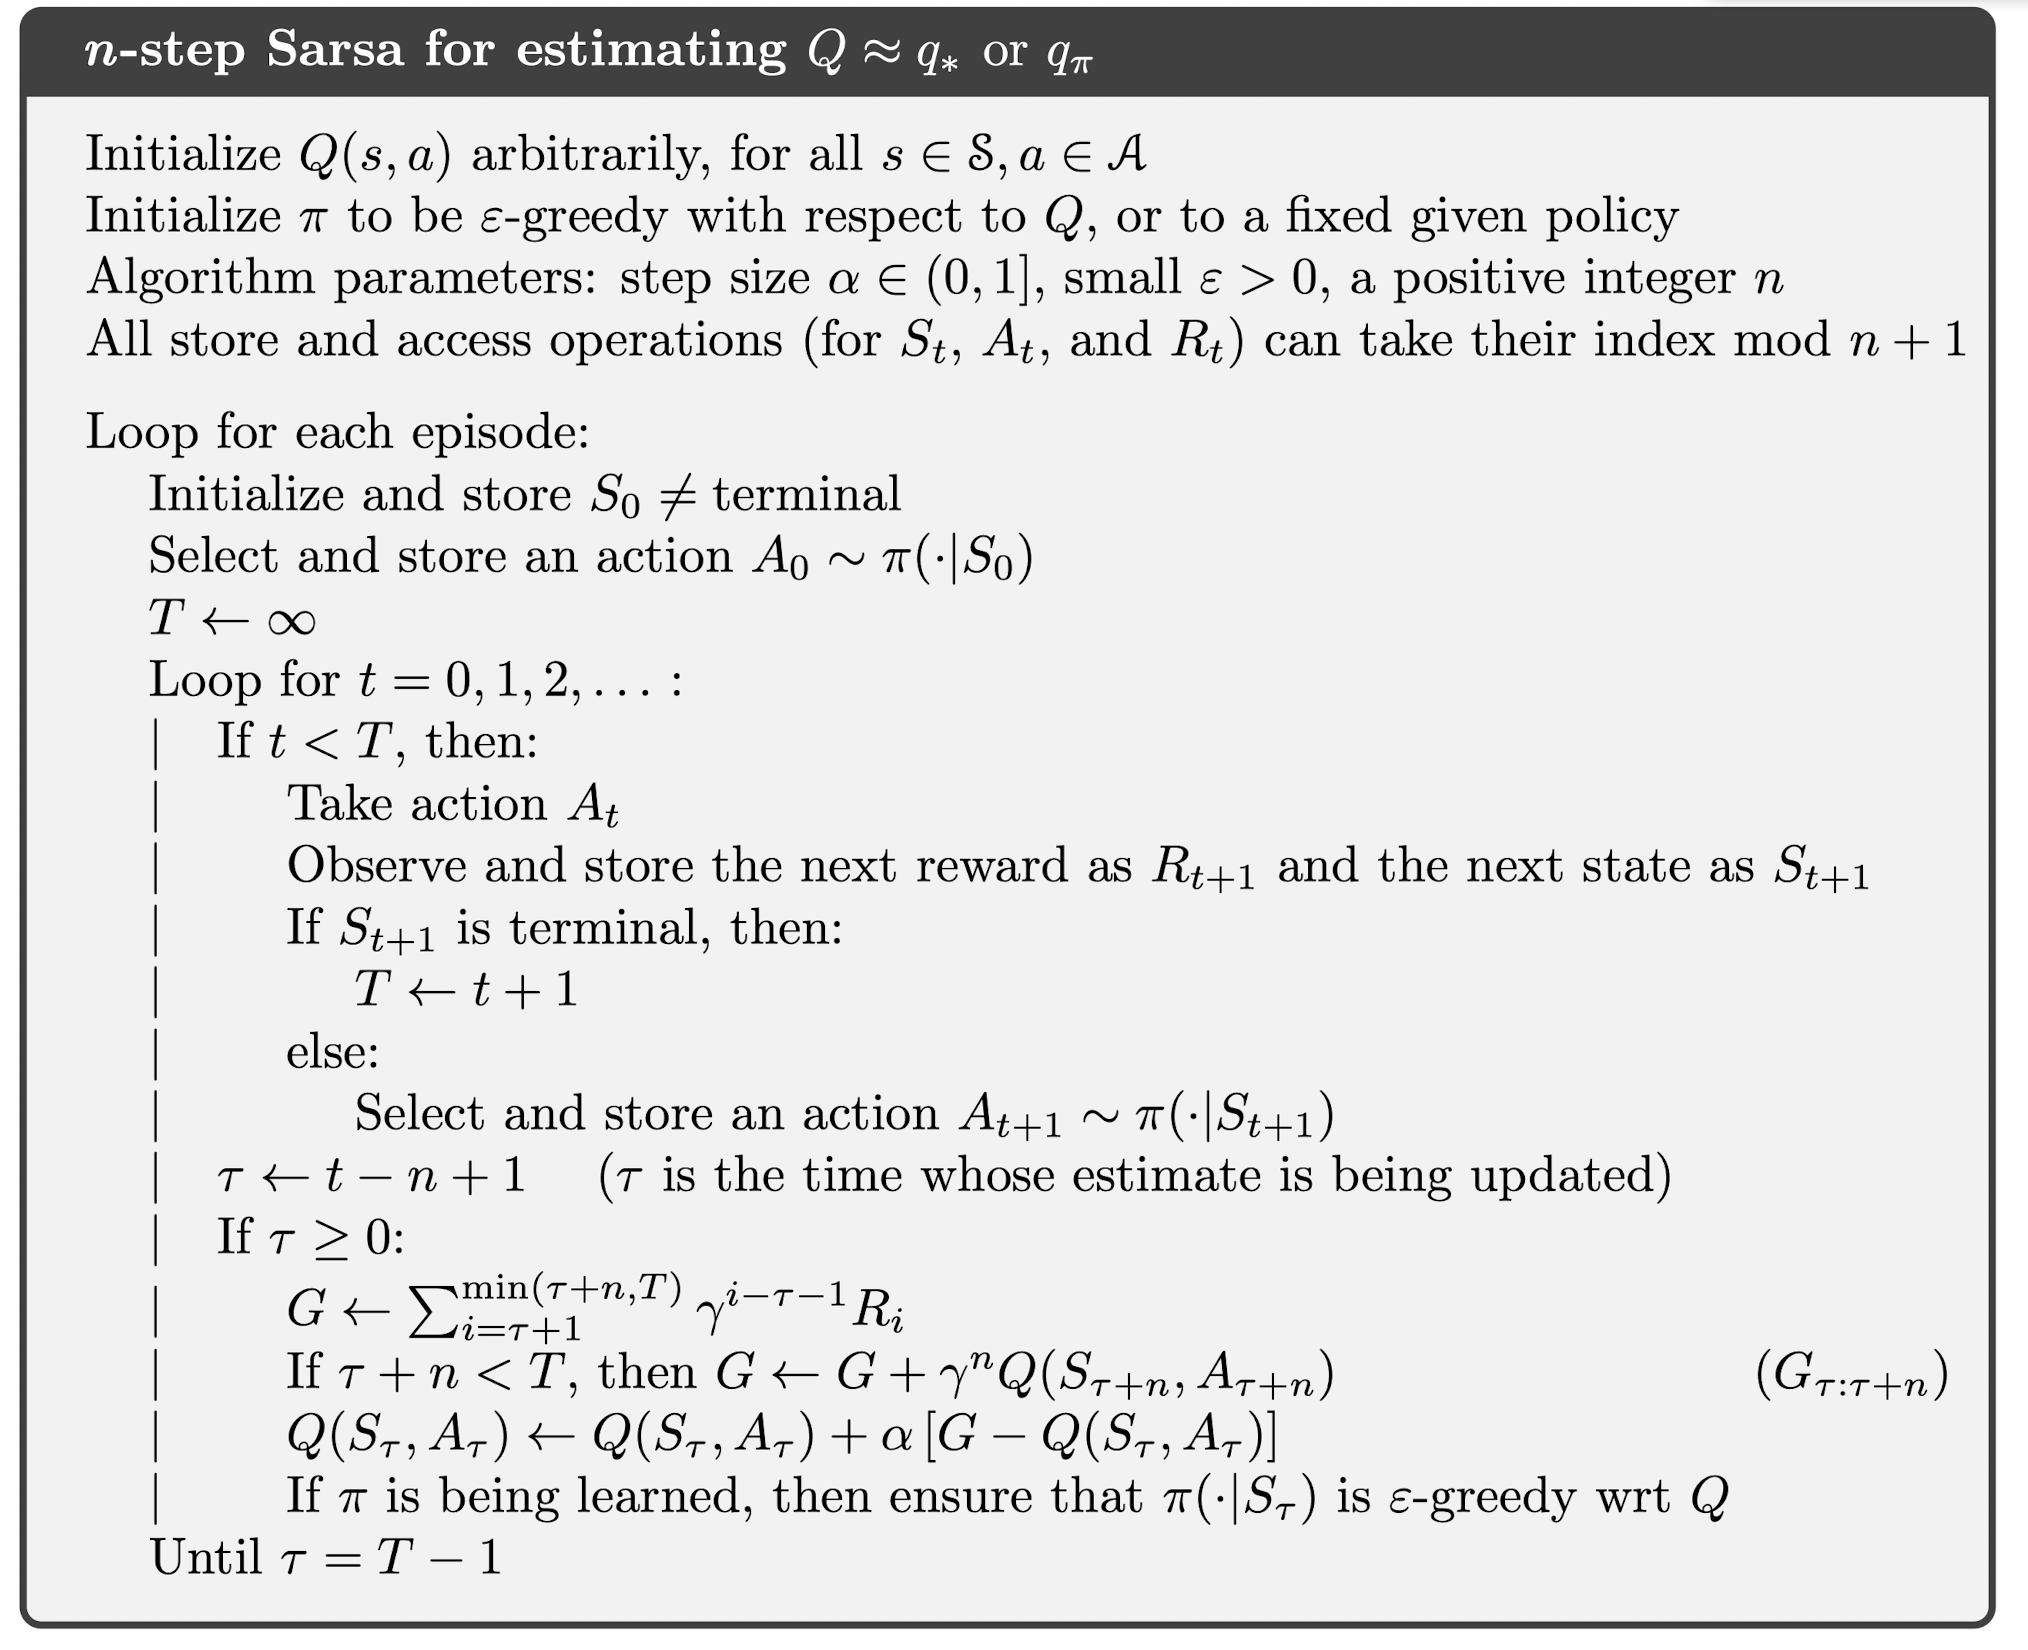

step: 10000, epsilon: 0.7247796636779303, total reward: 174.0, avarge success rate: 0.0174, avarage reward per step: 0.0016448432693814848
step: 20000, epsilon: 0.5253055608810939, total reward: 457.0, avarge success rate: 0.0283, avarage reward per step: 0.0027013304345139956
step: 30000, epsilon: 0.3807307877435458, total reward: 829.0, avarge success rate: 0.0372, avarage reward per step: 0.003376068677782078
step: 40000, epsilon: 0.2759459322926006, total reward: 1342.0, avarge success rate: 0.0513, avarage reward per step: 0.004453536159800444
step: 50000, epsilon: 0.20000000000032403, total reward: 2083.0, avarge success rate: 0.0741, avarage reward per step: 0.006075697058872014
step: 60000, epsilon: 0.1449559327358209, total reward: 3067.0, avarge success rate: 0.0984, avarage reward per step: 0.007315583898440914
step: 70000, epsilon: 0.10506111217638898, total reward: 4310.0, avarge success rate: 0.1243, avarage reward per step: 0.008921789293235567
step: 80000, epsilon: 0.07

100%|██████████| 10000/10000 [00:03<00:00, 2741.34it/s]


Success rate = 0.4425


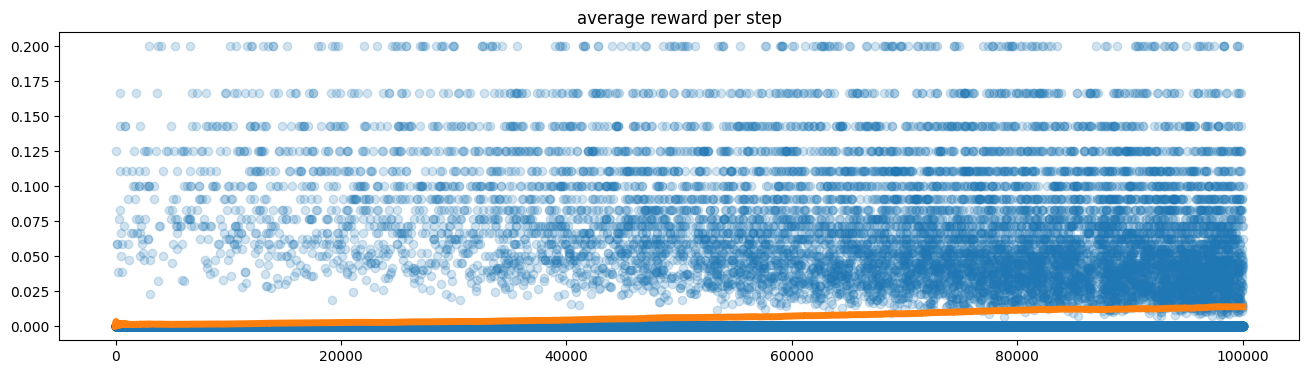

In [6]:
# Policy Eval
# Params
max_episode = 100000
video_path = os.path.join(ROOT, "video/n_step_td_on_policy.mp4")
random_seed = 101

# Initialize
history = []
total_reward = 0
report_interval = max_episode // 10
# set random seeds
rng = np.random.default_rng(random_seed)
np.random.seed(random_seed)
# epsilon decay
epsilon_schedule = create_decay_schedule(max_episode)
lr_schedule = create_decay_schedule(max_episode)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4",
               is_slippery=True, render_mode='rgb_array')
env.np_random = rng

# Create Agent
agent = nStepSarsaAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    discount_rate=0.9,
    epsilon=0.2,
    learning_rate=0.5,
    n=1
)
# Start Learning
for i in range(max_episode):
    reward, steps = agent.play_episode(env, epsilon=epsilon_schedule[i])
    history.append(reward / steps)
    total_reward += reward
    if i % report_interval == 0 and i != 0:
        print(
            f"step: {i}, epsilon: {epsilon_schedule[i]}, total reward: {total_reward}, avarge success rate: {np.sum([x > 0 for x in history[-report_interval:-1]])/report_interval}, avarage reward per step: {np.mean(history[-report_interval:-1])}")
print(f"\nrewarding episodes: {total_reward}")

# For off policy learning only: get greedy policy (no exploration)
agent._policy = get_epsilon_greedy_policy_from_action_values(agent._Q)
# Run Eval
success_rate = estimate_success_rate(agent, env, 10000)
print(f"Success rate = {success_rate}")
# play last episode with video recording
#agent.play_episode(env, learning=False, video_path=video_path)

plot_history(history)
# html=render_mp4(video_path)
# HTML(html)

# Summary

## Temporal Difference on policy learning 
Temporal difference combines Monte Carlo with dynamic programming.
```
V(s) = V(s) + learning_rate * (reward + discount_rate * V(s') - V(s))
```
The last part is also called TD-error:
```
td_error = (reward + discount_rate * V(s') - V(s))
```

### Sarsa
Sarsa requires `(state, action, reward, next_state, next_action)` to update action_values `_Q` and use that to create a epsilon-greedy policy `_policy`.

What makes it on-policy learning is that fact that `next_action` is both 
1. the action the agent is taking  -> behavior policy
2. the action the agent is using to update the action values `_Q` (policy evluation) -> target policy

The conflict is that 1 requires exploration to learn from unexplored environment. But 2 is affected by such exploration (because next action will not always be the optimal one, affecting the value of `_Q`). 


